In [1]:
from lib.rendering.renderer import SignedDistanceFunction, Camera, Light, Scene, SphereTracer
from lib.models.siamese import Siamese
import torch

ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
sdf = SignedDistanceFunction(ckpt_path=ckpt_path, obj_idx=34)
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
scene = Scene(sdf=sdf, camera=camera, light=light)

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
from lib.rendering.utils import visualize_depth

depth = scene.render_depth() 
visualize_depth(depth)

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacty of 10.75 GiB of which 38.06 MiB is free. Process 4148199 has 888.00 MiB memory in use. Process 4189807 has 764.00 MiB memory in use. Process 311347 has 420.00 MiB memory in use. Process 1923996 has 8.15 GiB memory in use. Including non-PyTorch memory, this process has 478.00 MiB memory in use. Of the allocated memory 277.80 MiB is allocated by PyTorch, and 12.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

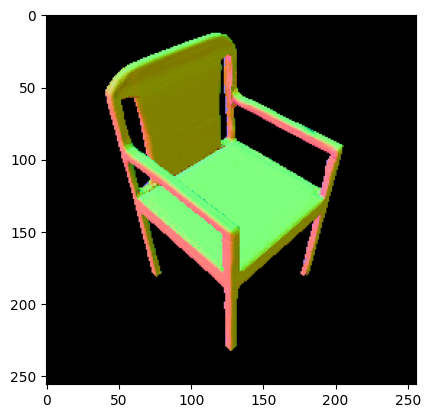

In [3]:
from lib.rendering.utils import visualize_normals

normals, _ = scene.render_normals()
visualize_normals(normals)

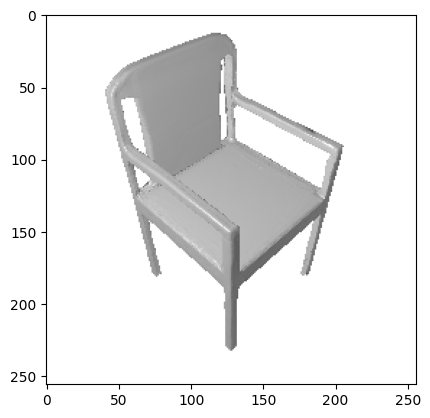

In [4]:
from lib.rendering.utils import visualize_image

image = scene.render_image()
visualize_image(image)

  0%|          | 0/1000 [00:00<?, ?it/s]

0 tensor(62.2567, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


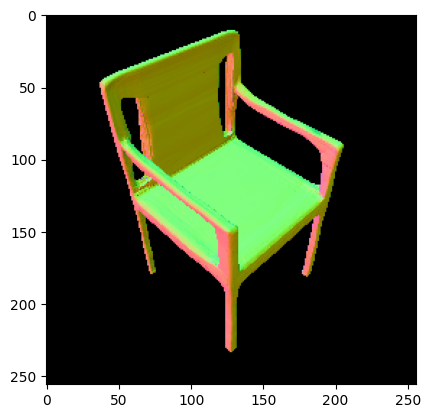

  1%|          | 10/1000 [00:03<03:10,  5.19it/s]

10 tensor(306.6490, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


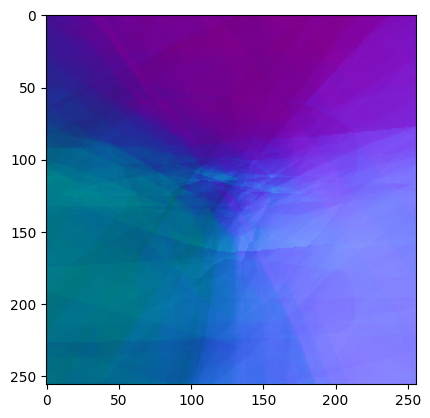

  2%|▏         | 20/1000 [00:04<02:09,  7.59it/s]

20 tensor(244.1935, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


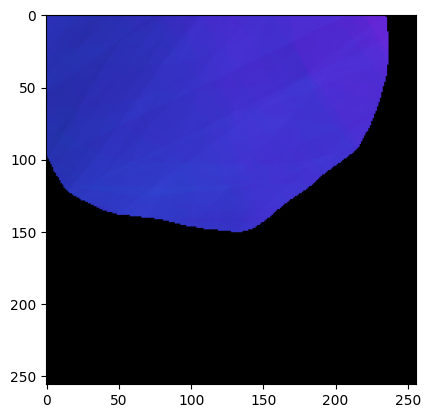

  3%|▎         | 30/1000 [00:05<02:04,  7.79it/s]

30 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


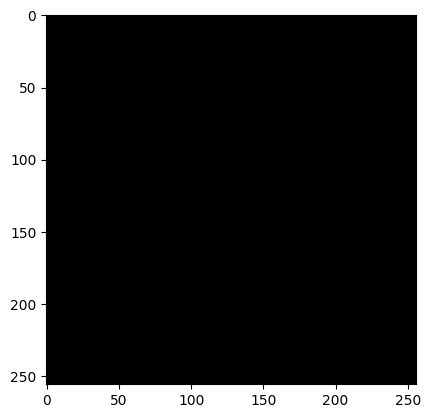

  4%|▍         | 40/1000 [00:07<02:03,  7.80it/s]

40 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


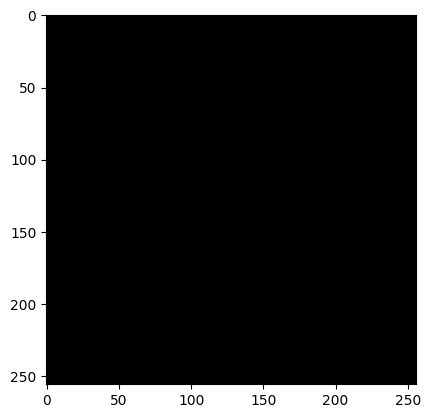

  5%|▌         | 50/1000 [00:08<02:02,  7.76it/s]

50 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


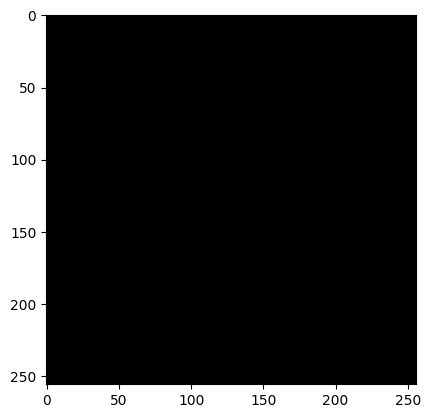

  6%|▌         | 60/1000 [00:09<02:01,  7.76it/s]

60 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


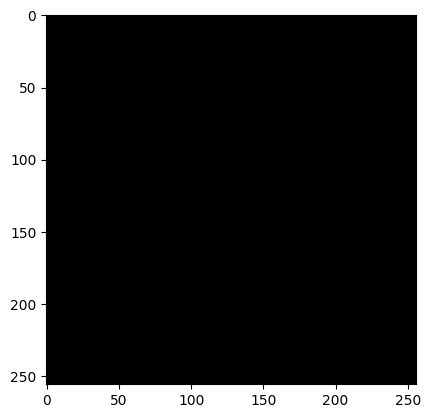

  7%|▋         | 70/1000 [00:11<01:59,  7.76it/s]

70 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


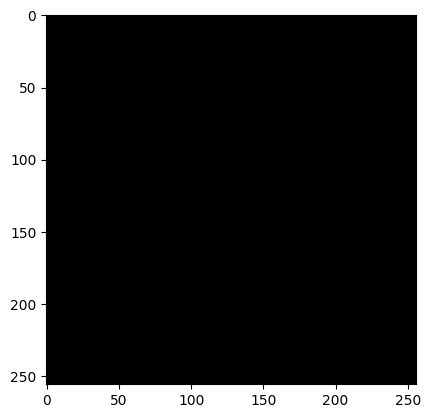

  8%|▊         | 80/1000 [00:12<01:58,  7.75it/s]

80 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


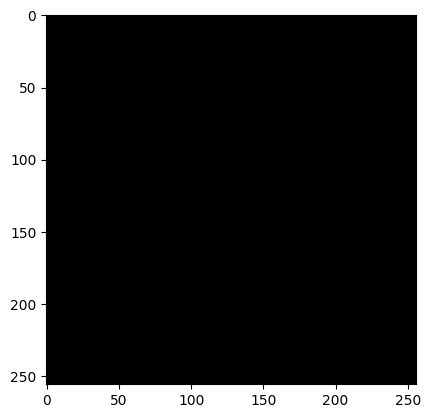

  9%|▉         | 90/1000 [00:14<01:57,  7.75it/s]

90 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


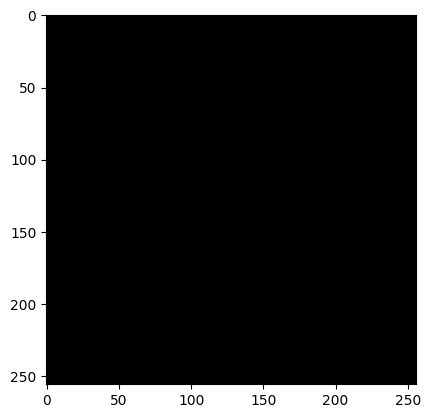

 10%|█         | 100/1000 [00:15<01:56,  7.72it/s]

100 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


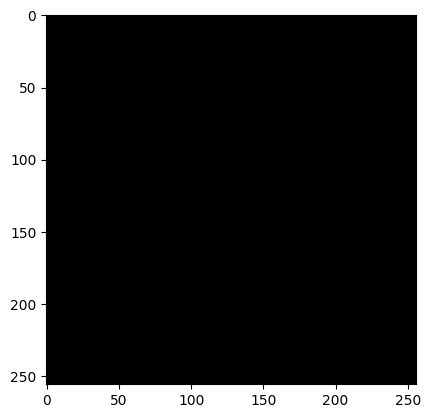

 11%|█         | 110/1000 [00:16<01:56,  7.66it/s]

110 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


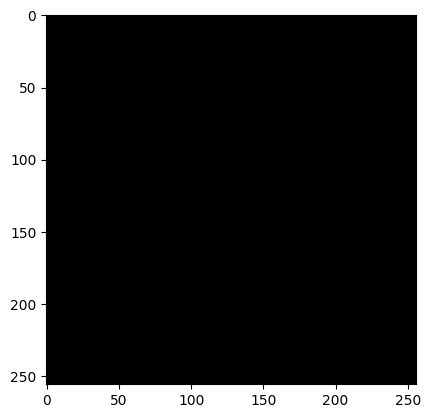

 12%|█▏        | 120/1000 [00:18<01:59,  7.38it/s]

120 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


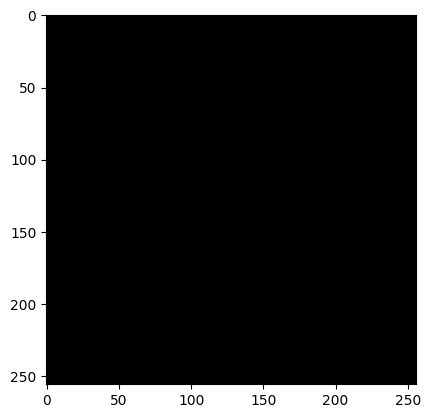

 13%|█▎        | 130/1000 [00:19<01:54,  7.60it/s]

130 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


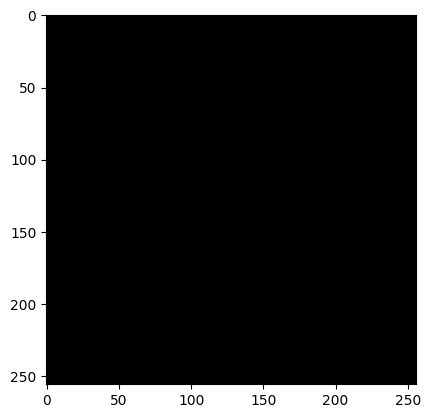

 14%|█▍        | 140/1000 [00:20<01:52,  7.61it/s]

140 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


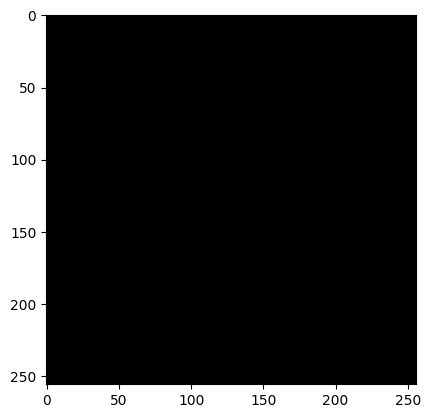

 15%|█▌        | 150/1000 [00:22<01:52,  7.52it/s]

150 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


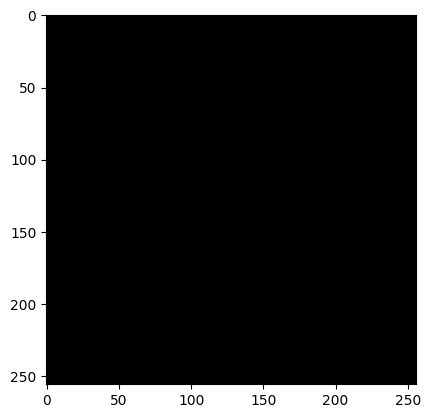

 16%|█▌        | 160/1000 [00:23<01:50,  7.63it/s]

160 tensor(126.5701, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


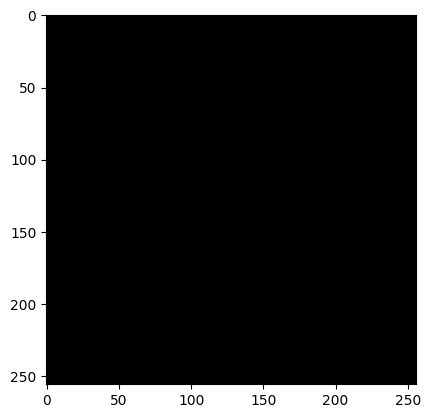

 16%|█▌        | 162/1000 [00:24<02:05,  6.67it/s]


KeyboardInterrupt: 

In [7]:
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import ToTensor
from lib.models.siamese import Siamese

import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from lib.rendering.renderer import SignedDistanceFunction, Camera, Light, Scene, SphereTracer

sdf_ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
siamese_ckpt_path = "/home/borth/sketch2shape/logs/save/siamese/checkpoints/last.ckpt"
sketch_path = "/home/borth/sketch2shape/data/siamese_chair_large/96d9944f46bd330979414e04132a8bef/sketches/00021.jpg"

# siamese = Siamese.load_from_checkpoint(siamese_ckpt_path)
sdf = SignedDistanceFunction(ckpt_path=sdf_ckpt_path, obj_idx=34)
sdf.lat_vec = sdf.lat_vec + torch.randn(sdf.lat_vec.shape).to("cuda") * 0.05
camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2)
light = Light(position=[1, 1, 0])
scene = Scene(sdf=sdf, camera=camera, light=light)
optimizer = Adam(sdf.model.parameters(), lr=1e-05)

# sketch = Image.open(sketch_path)
# sketch_emb = siamese.decoder(ToTensor()(sketch).to(sdf.device)[None])
# normalized_sketch_emb = torch.nn.functional.normalize(sketch_emb)

# plt.figure(figsize=(2, 2))
# plt.imshow(sketch)
# plt.show()

normals.requires_grad = True
for steps in tqdm(range(1000)):
    # image_emb = siamese.decoder(image[None])
    # normalized_image_emb = torch.nn.functional.normalize(image_emb)
    # loss = (sketch_emb @ image_emb.T).sum()
    target_normals, _ = scene.render_normals()
    loss = torch.norm(target_normals- normals)

    if steps % 10 == 0: 
        print(steps, loss)
        visualize_normals(target_normals) 

    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()


In [13]:
target_normals.reshape(-1, 1).shape

torch.Size([196608, 1])

In [58]:
from lib.utils import load_config
from lightning import Trainer
from lib.eval.tester import SiameseTester
import hydra

cfg = load_config("eval_siamese", overrides=["+experiment=eval"])
tester = SiameseTester(model=siamese.decoder)
datamodule = hydra.utils.instantiate(cfg.data, train=False)
datamodule.setup("all")
trainer = Trainer(
    accelerator="gpu",
    max_epochs=1,
    enable_checkpointing=False,
)
trainer.validate(
    tester,
    dataloaders=[
        datamodule.train_dataloader(),
        datamodule.val_dataloader(),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/borth/sketch2shape/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{}, {}]